<a href="https://colab.research.google.com/github/Yuto-Kishi/ECHONET-Lite/blob/main/est0113.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📥 Loading CSV...

RUN: Living

--------------------------------------------------------------------------------------------
[Living] setting=all | features=104 | train=10945 test=2737
  count_dist_test: {0: 2442, 1: 218, 2: 77}
--------------------------------------------------------------------------------------------

=== Living / all | Occupancy (0 vs >0) ===
Accuracy      : 0.9795
Balanced Acc  : 0.9379
F1 (macro)    : 0.9458
Confusion Mat :
[[2420   22]
 [  34  261]]


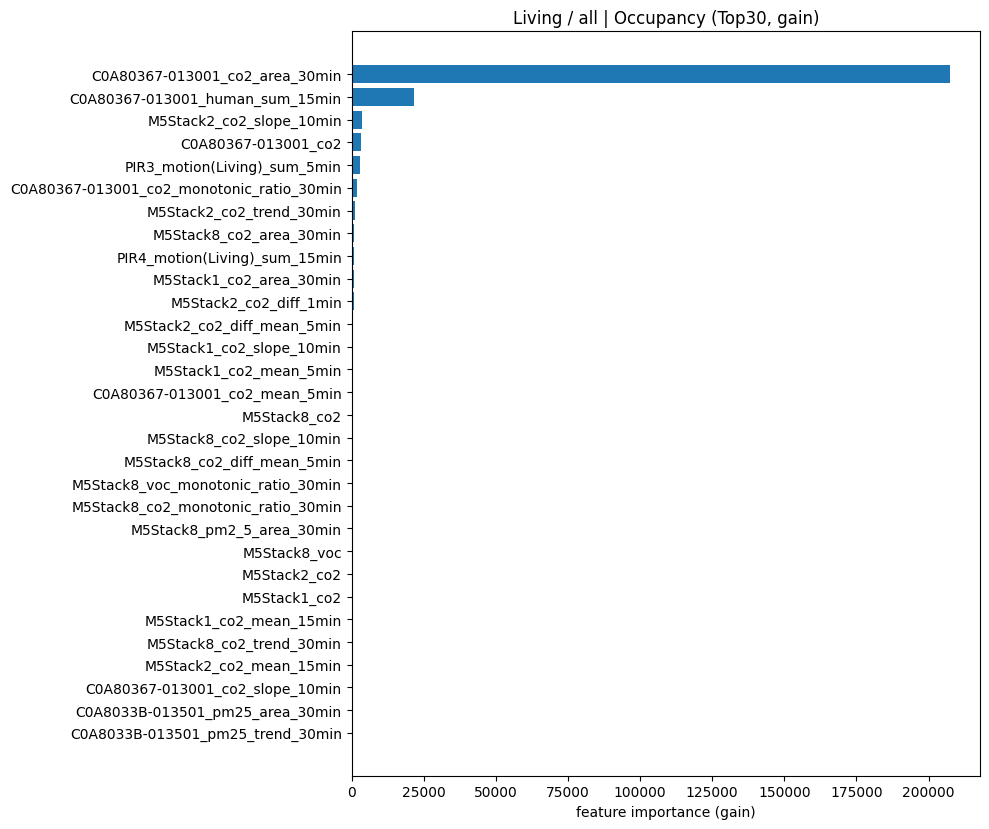

[Saved] ./out_lgbm_features/importance_Living_all_occ.csv

=== Living / all | Count (1 vs 2) [occupied only] ===
Accuracy      : 0.4034
Balanced Acc  : 0.4157
F1 (macro)    : 0.3850
Confusion Mat :
[[ 85 133]
 [ 43  34]]


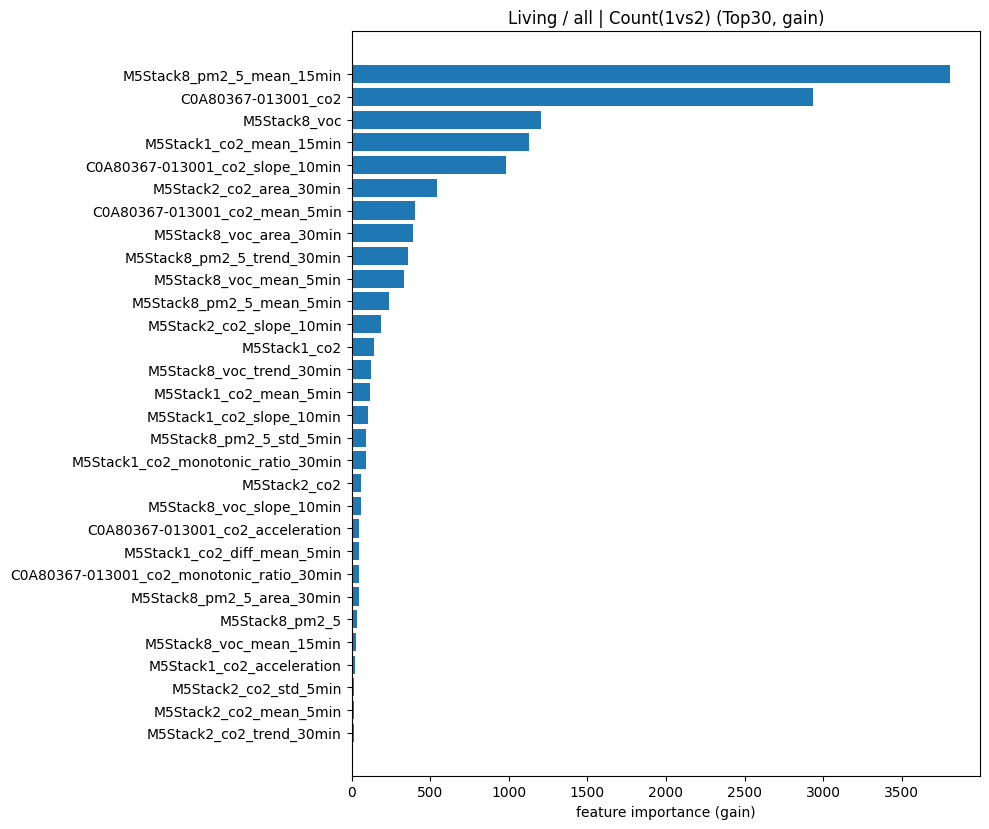

[Saved] ./out_lgbm_features/importance_Living_all_cnt12.csv

=== Living / all | Final (0/1/2 by 2-stage) ===
Accuracy      : 0.9204
Balanced Acc  : 0.5769
F1 (macro)    : 0.5522
Confusion Mat :
[[2420    9   13]
 [  34   65  119]
 [   0   43   34]]

--------------------------------------------------------------------------------------------
[Living] setting=appliance_only | features=94 | train=10945 test=2737
  count_dist_test: {0: 2442, 1: 218, 2: 77}
--------------------------------------------------------------------------------------------

=== Living / appliance_only | Occupancy (0 vs >0) ===
Accuracy      : 0.9649
Balanced Acc  : 0.8909
F1 (macro)    : 0.9054
Confusion Mat :
[[2406   36]
 [  60  235]]


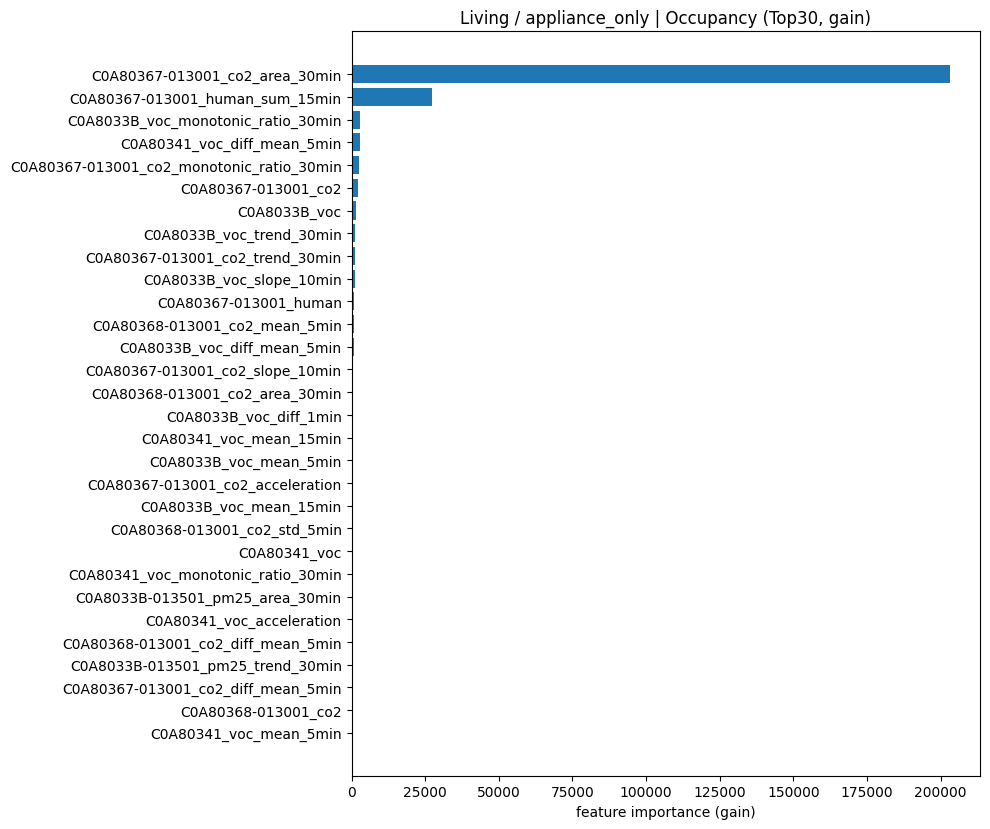

[Saved] ./out_lgbm_features/importance_Living_appliance_only_occ.csv

=== Living / appliance_only | Count (1 vs 2) [occupied only] ===
Accuracy      : 0.5864
Balanced Acc  : 0.6614
F1 (macro)    : 0.5757
Confusion Mat :
[[110 108]
 [ 14  63]]


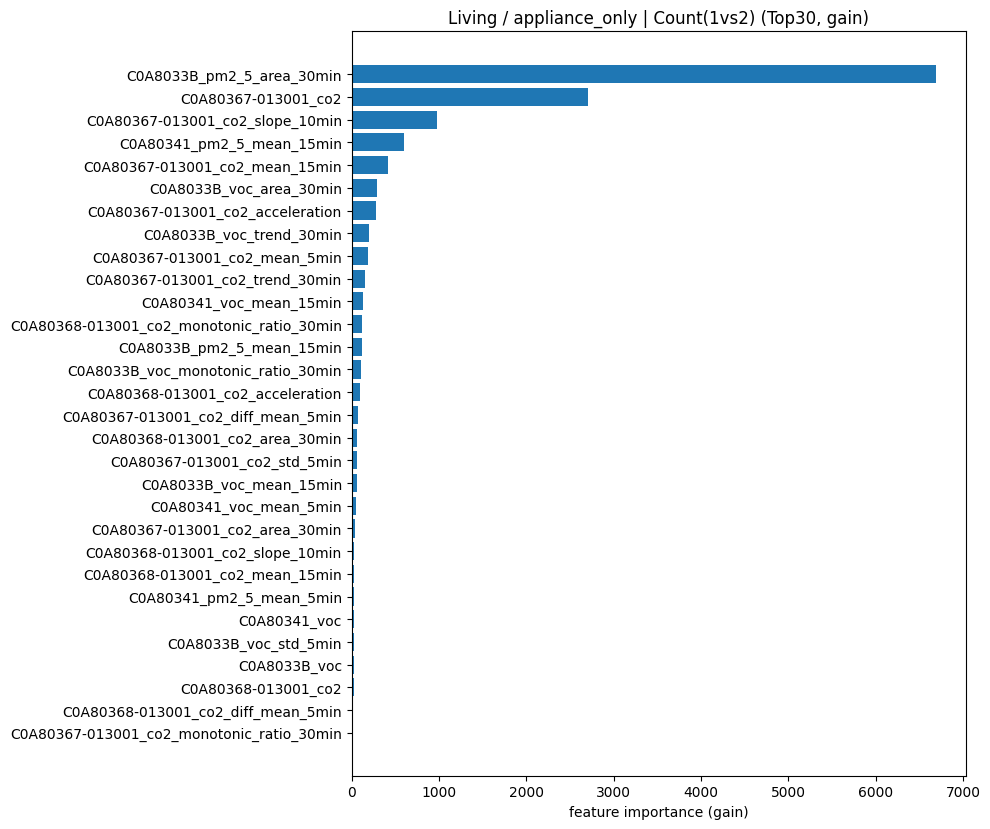

[Saved] ./out_lgbm_features/importance_Living_appliance_only_cnt12.csv

=== Living / appliance_only | Final (0/1/2 by 2-stage) ===
Accuracy      : 0.9288
Balanced Acc  : 0.7128
F1 (macro)    : 0.6550
Confusion Mat :
[[2406   33    3]
 [  60   73   85]
 [   0   14   63]]

RUN: Japanese

--------------------------------------------------------------------------------------------
[Japanese] setting=all | features=104 | train=10945 test=2737
  count_dist_test: {0: 2498, 1: 176, 2: 63}
--------------------------------------------------------------------------------------------

=== Japanese / all | Occupancy (0 vs >0) ===
Accuracy      : 0.9708
Balanced Acc  : 0.9083
F1 (macro)    : 0.9083
Confusion Mat :
[[2458   40]
 [  40  199]]


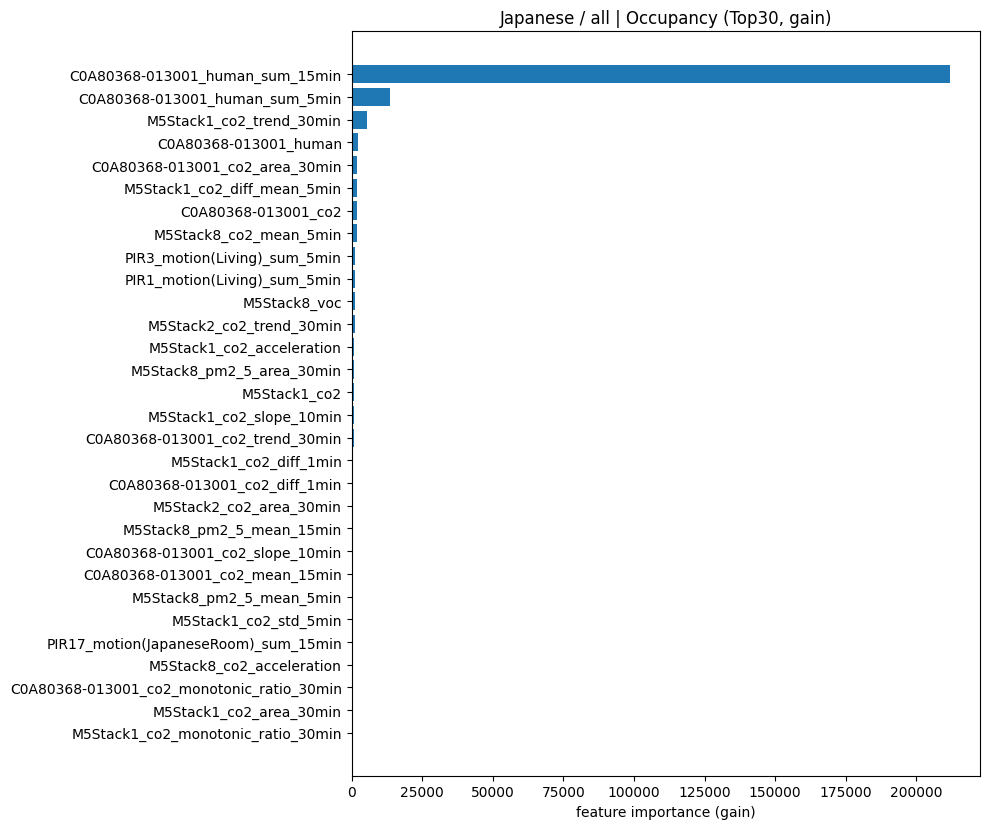

[Saved] ./out_lgbm_features/importance_Japanese_all_occ.csv

=== Japanese / all | Count (1 vs 2) [occupied only] ===
Accuracy      : 0.8326
Balanced Acc  : 0.8456
F1 (macro)    : 0.8057
Confusion Mat :
[[144  32]
 [  8  55]]


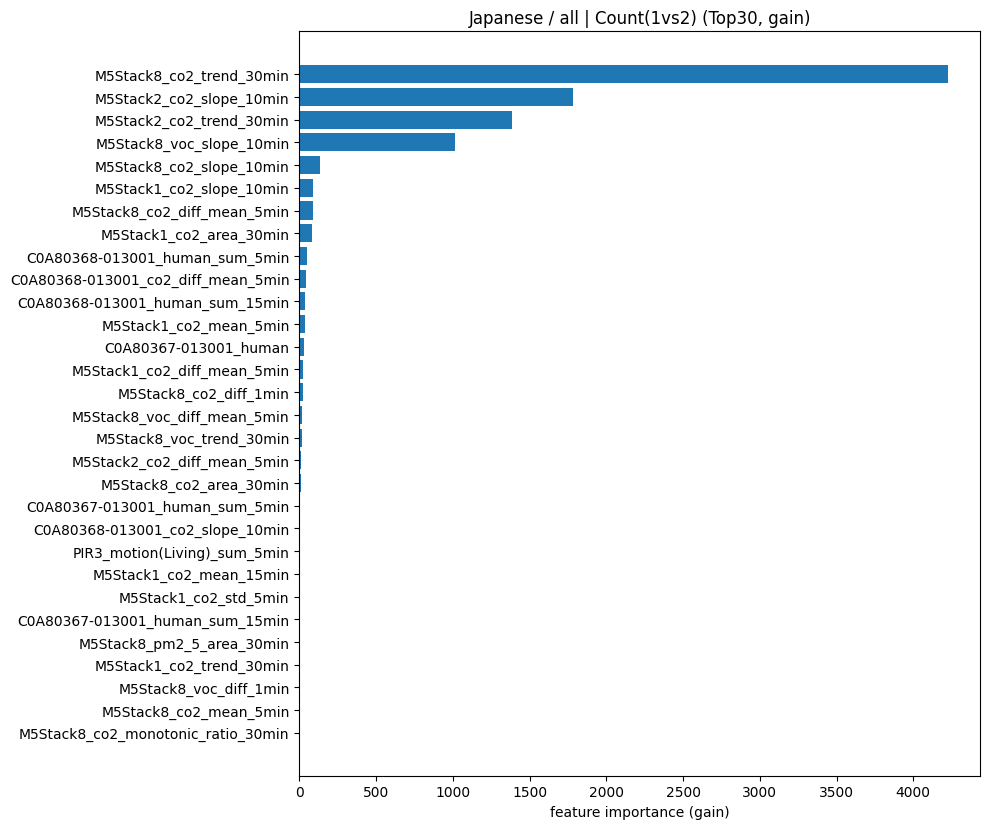

[Saved] ./out_lgbm_features/importance_Japanese_all_cnt12.csv

=== Japanese / all | Final (0/1/2 by 2-stage) ===
Accuracy      : 0.9580
Balanced Acc  : 0.8254
F1 (macro)    : 0.7950
Confusion Mat :
[[2458   36    4]
 [  40  109   27]
 [   0    8   55]]

--------------------------------------------------------------------------------------------
[Japanese] setting=appliance_only | features=94 | train=10945 test=2737
  count_dist_test: {0: 2498, 1: 176, 2: 63}
--------------------------------------------------------------------------------------------

=== Japanese / appliance_only | Occupancy (0 vs >0) ===
Accuracy      : 0.9700
Balanced Acc  : 0.9079
F1 (macro)    : 0.9064
Confusion Mat :
[[2456   42]
 [  40  199]]


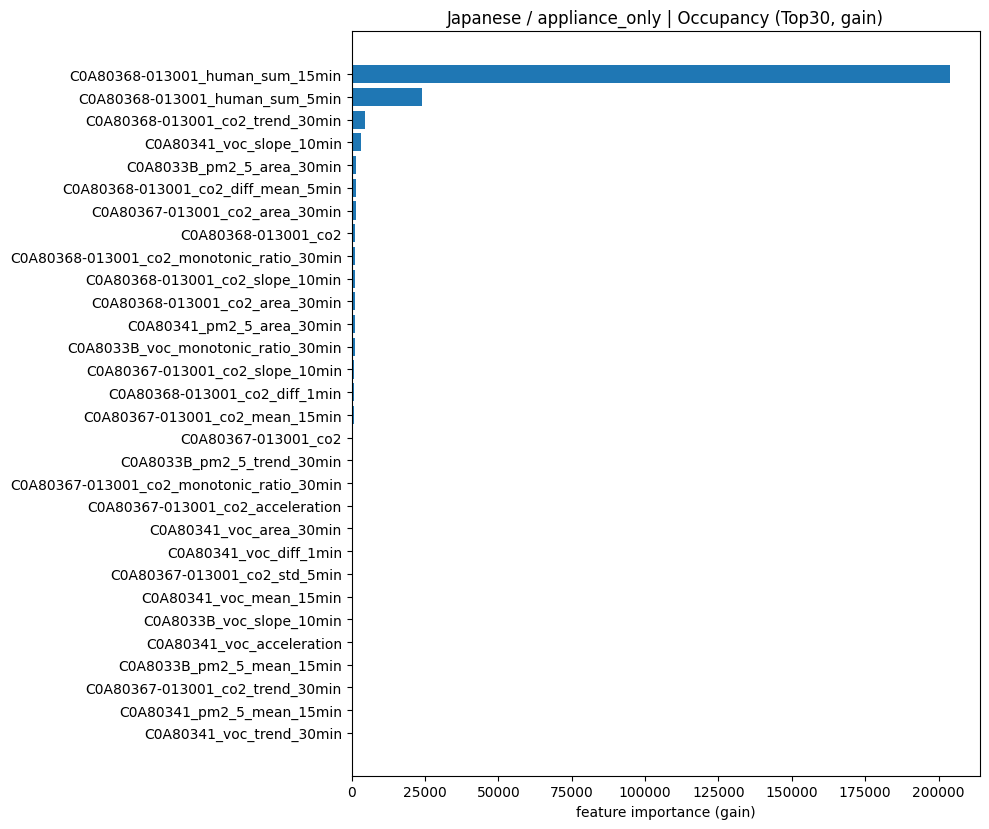

[Saved] ./out_lgbm_features/importance_Japanese_appliance_only_occ.csv

=== Japanese / appliance_only | Count (1 vs 2) [occupied only] ===
Accuracy      : 0.8912
Balanced Acc  : 0.8956
F1 (macro)    : 0.8687
Confusion Mat :
[[156  20]
 [  6  57]]


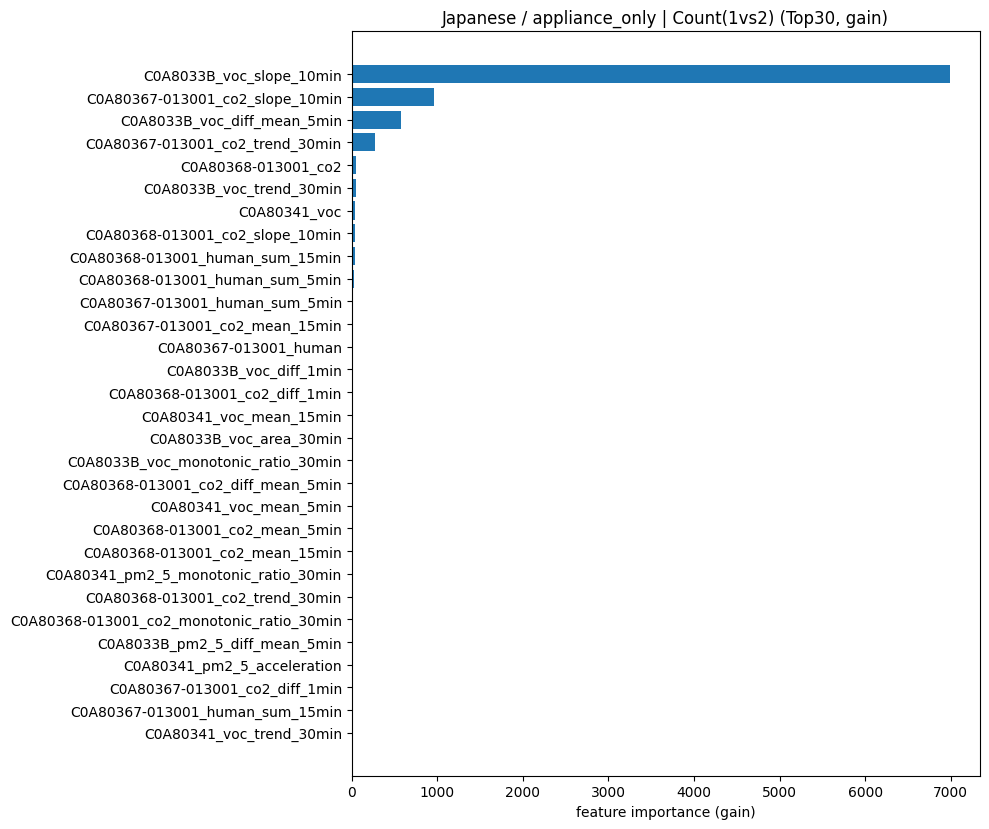

[Saved] ./out_lgbm_features/importance_Japanese_appliance_only_cnt12.csv

=== Japanese / appliance_only | Final (0/1/2 by 2-stage) ===
Accuracy      : 0.9613
Balanced Acc  : 0.8528
F1 (macro)    : 0.8332
Confusion Mat :
[[2456   42    0]
 [  40  118   18]
 [   0    6   57]]

✅ Done.
Saved importance CSVs in: ./out_lgbm_features


In [6]:
# ============================================================
# LightGBM: 2段モデル（在不在 0vs>0 → 在室のみ 1vs2）
# Living / Japanese（和室）それぞれ
# 追加特徴量:
#  - trend_30min（30分回帰傾き）
#  - monotonic_ratio_30min（上昇割合）
#  - acceleration（傾きの変化）
#  - area_30min（基準からの累積面積）
#  - PM2.5 / VOC の変化率（slope/trend等）
#
# 出力は「必要な評価指標のみ」に絞る（LightGBMログ抑制）
#
# さらに feature importance を2種類出す：
#  A) all（家電 + M5Stack + PIR）
#  B) appliance_only（家電= C0A8033B/C0A80341/C0A80367/C0A80368 のみ）
#  - importance は “全特徴” をCSV保存し、図は上位TOPKのみ表示（多すぎるため）
# ============================================================

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from lightgbm import LGBMClassifier


# =========================
# 設定
# =========================
# 既存のまま使うならこれ
#CSV_PATH = "./smart_home_merged_all.csv"
# 新しい列名にしたCSVを使うならこちらに変更
CSV_PATH = "/content/smart_home_renamed_with_timestamp.csv"

TIME_COL = "timestamp"     # 必要なら修正
RESAMPLE_RULE = "1min"     # 1分に揃える
TRAIN_RATIO = 0.80         # 時系列 split
RANDOM_STATE = 42
TOPK_IMPORTANCE = 30

# 保存先（必要なら変更）
OUT_DIR = "./out_lgbm_features"
os.makedirs(OUT_DIR, exist_ok=True)


# =========================
# Utility
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)

def time_split(df: pd.DataFrame, train_ratio: float):
    n = len(df)
    n_tr = int(n * train_ratio)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)
    return tr_idx, te_idx

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    # 未来を使わない：ffillのみ
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    return dfr

def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    """
    rolling linear regression slope over last `window` points.
    time index assumed equally spaced (1min). output unit: (value / min)
    """
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_mean = t.mean()
    t_centered = t - t_mean
    denom = np.sum(t_centered ** 2)  # constant

    # apply over window
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        a_mean = np.mean(a)
        return np.dot(t_centered, (a - a_mean)) / denom  # per step (1min)

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    """
    ratio of positive diffs in last window minutes.
    """
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    """
    area over last window minutes relative to baseline=min over window.
    (sum(y - min_window))  -> "ppm*min" っぽい量
    """
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    area = (y - base).rolling(window, min_periods=1).sum()
    return area.fillna(0.0)

def eval_compact(title: str, y_true, y_pred, labels=None):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(f"\n=== {title} ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Balanced Acc  : {bacc:.4f}")
    print(f"F1 (macro)    : {f1m:.4f}")
    print("Confusion Mat :")
    print(cm)

def save_and_plot_importance(model: LGBMClassifier, feature_names, title: str, tag: str, topk: int = 30):
    booster = model.booster_
    gains = booster.feature_importance(importance_type="gain")
    imp = pd.Series(gains, index=feature_names).sort_values(ascending=False)

    # 全特徴importanceを保存（要望: "全てのfeature importance"）
    imp_df = imp.reset_index()
    imp_df.columns = ["feature", "gain"]
    csv_path = os.path.join(OUT_DIR, f"importance_{tag}.csv")
    imp_df.to_csv(csv_path, index=False)

    # 図は上位のみ（全件描画は長くて見にくいので）
    s = imp.head(topk)[::-1]
    plt.figure(figsize=(10, max(4, 0.28 * len(s))))
    plt.barh(s.index, s.values)
    plt.title(f"{title} (Top{topk}, gain)")
    plt.xlabel("feature importance (gain)")
    plt.tight_layout()
    plt.show()

    print(f"[Saved] {csv_path}")


# =========================
# 特徴量生成
# =========================
def build_numeric_dyn_features(df: pd.DataFrame, cols: list[str], prefix: str, window_trend=30) -> pd.DataFrame:
    """
    任意の数値列に対して、変化率・trend・単調増加割合・加速度・areaを作る
    """
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue

        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill()

        # raw
        feats[f"{prefix}{c}"] = s

        # basic diffs/slopes
        feats[f"{prefix}{c}_diff_1min"] = s.diff().fillna(0.0)
        feats[f"{prefix}{c}_slope_10min"] = ((s - s.shift(10)) / 10.0).fillna(0.0)  # per min
        feats[f"{prefix}{c}_diff_mean_5min"] = (s - s.rolling(5, min_periods=1).mean()).fillna(0.0)

        # windows
        feats[f"{prefix}{c}_mean_5min"] = s.rolling(5, min_periods=1).mean().fillna(0.0)
        feats[f"{prefix}{c}_mean_15min"] = s.rolling(15, min_periods=1).mean().fillna(0.0)
        feats[f"{prefix}{c}_std_5min"] = s.rolling(5, min_periods=1).std().fillna(0.0)

        # requested 30min features
        trend30 = _rolling_linreg_slope(s, window_trend)  # per min
        feats[f"{prefix}{c}_trend_30min"] = trend30
        feats[f"{prefix}{c}_monotonic_ratio_30min"] = _monotonic_ratio(s, window_trend)
        feats[f"{prefix}{c}_area_30min"] = _area_from_baseline(s, window_trend)

        # acceleration: slope change (10min slope - 30min trend) as proxy
        slope10 = feats[f"{prefix}{c}_slope_10min"]
        feats[f"{prefix}{c}_acceleration"] = (slope10 - trend30).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        feats[f"{c}_sum_5min"] = s.rolling(5, min_periods=1).sum().fillna(0.0)
        feats[f"{c}_sum_15min"] = s.rolling(15, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X


# =========================
# 列選択
# =========================
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

def pick_room_columns(df: pd.DataFrame, room: str):
    """
    Living / Japanese それぞれで
    - label_count
    - CO2系（家電CO2 + M5Stack CO2）
    - PM2.5系（家電/M5Stackのpm2_5）
    - VOC系（家電/M5Stackのvoc）
    - human/PIR
    - appliance_only 用の列（家電prefixのみの CO2/PM2.5/VOC/human 等）
    """
    if room == "Living":
        label_count = "Label_Living_Count"
        base_co2 = ["C0A80367-013001_co2"]  # living AC
        base_human = ["C0A80367-013001_human"] if "C0A80367-013001_human" in df.columns else []
        # living purifier
        appliance_cols = [c for c in df.columns if c.startswith("C0A8033B-013501_") or c.startswith("C0A80367-013001_")]

        # PIR (explicit)
        pir_cols = [c for c in df.columns if c.startswith("PIR")]

    elif room == "Japanese":
        label_count = "Label_Japanese_Count"
        # japanese AC
        base_co2 = [c for c in df.columns if c.startswith("C0A80368-013001_") and c.endswith("_co2")]
        base_human = ["C0A80368-013001_human"] if "C0A80368-013001_human" in df.columns else []
        # japanese purifier
        appliance_cols = [c for c in df.columns if c.startswith("C0A80341-013501_") or c.startswith("C0A80368-013001_")]

        # PIR (explicit)
        pir_cols = [c for c in df.columns if c.startswith("PIR")]
    else:
        raise ValueError("room must be Living or Japanese")

    # M5Stack subset you requested (1,2,8)
    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]

    # CO2 columns
    m5_co2 = [c for c in m5_cols if c.endswith("_co2")]
    co2_cols = [c for c in (base_co2 + m5_co2) if c in df.columns]

    # PM2.5 columns (several naming patterns: pm2_5, pm2.5 etc)
    def is_pm25(name: str) -> bool:
        n = name.lower()
        return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

    pm25_cols = [c for c in (appliance_cols + m5_cols) if is_pm25(c)]

    # VOC columns (voc)
    voc_cols = [c for c in (appliance_cols + m5_cols) if "voc" in c.lower()]

    # human + PIR: human is boolish; PIR is typically motion boolish
    human_cols = []
    human_cols += base_human
    # C0A..._human (if any) + PIR*
    human_cols += [c for c in df.columns if c.endswith("_human") and c.startswith(APPLIANCE_PREFIXES)]
    human_cols += pir_cols

    # 重複除去
    def uniq(xs):
        return list(dict.fromkeys([x for x in xs if x in df.columns]))

    co2_cols = uniq(co2_cols)
    pm25_cols = uniq(pm25_cols)
    voc_cols = uniq(voc_cols)
    human_cols = uniq(human_cols)
    appliance_cols = uniq(appliance_cols)

    # appliance_only: 家電prefixだけから CO2/PM2.5/VOC + human
    appliance_only_num = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    appliance_only_co2 = [c for c in appliance_only_num if c.endswith("_co2")]
    appliance_only_pm25 = [c for c in appliance_only_num if is_pm25(c)]
    appliance_only_voc = [c for c in appliance_only_num if "voc" in c.lower()]
    appliance_only_human = [c for c in appliance_only_num if c.endswith("_human")]

    appliance_only_co2 = uniq(appliance_only_co2)
    appliance_only_pm25 = uniq(appliance_only_pm25)
    appliance_only_voc = uniq(appliance_only_voc)
    appliance_only_human = uniq(appliance_only_human)

    return {
        "label_count": label_count,
        "co2_cols": co2_cols,
        "pm25_cols": pm25_cols,
        "voc_cols": voc_cols,
        "human_cols": human_cols,
        "appliance_only_co2": appliance_only_co2,
        "appliance_only_pm25": appliance_only_pm25,
        "appliance_only_voc": appliance_only_voc,
        "appliance_only_human": appliance_only_human,
    }


# =========================
# 学習（2段）
# =========================
def train_lgbm_classifier(**kwargs) -> LGBMClassifier:
    # LightGBMのログを出さない：verbose=-1 を徹底
    return LGBMClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1,
        **kwargs
    )

def run_one_setting(df: pd.DataFrame, room: str, setting_name: str, cols_pack: dict):
    label_count = cols_pack["label_count"]

    if label_count not in df.columns:
        print(f"[SKIP] {room}: {label_count} not found")
        return

    # ラベル（0/1/2 only）
    y_count = pd.to_numeric(df[label_count], errors="coerce")
    y_count = y_count.where(y_count.isin([0, 1, 2]), np.nan)
    y_count = y_count.ffill().fillna(0).astype(int)

    y_occ = (y_count > 0).astype(int)

    # 特徴量セット切替
    if setting_name == "all":
        co2_cols = cols_pack["co2_cols"]
        pm25_cols = cols_pack["pm25_cols"]
        voc_cols = cols_pack["voc_cols"]
        human_cols = cols_pack["human_cols"]
    elif setting_name == "appliance_only":
        co2_cols = cols_pack["appliance_only_co2"]
        pm25_cols = cols_pack["appliance_only_pm25"]
        voc_cols = cols_pack["appliance_only_voc"]
        human_cols = cols_pack["appliance_only_human"]  # PIRなし
    else:
        raise ValueError("setting_name must be all or appliance_only")

    # 数値（CO2/PM2.5/VOC）特徴量
    X_co2 = build_numeric_dyn_features(df, co2_cols, prefix="", window_trend=30) if len(co2_cols) else pd.DataFrame(index=df.index)
    X_pm25 = build_numeric_dyn_features(df, pm25_cols, prefix="", window_trend=30) if len(pm25_cols) else pd.DataFrame(index=df.index)
    X_voc = build_numeric_dyn_features(df, voc_cols, prefix="", window_trend=30) if len(voc_cols) else pd.DataFrame(index=df.index)

    # human/PIR（bool系）
    X_human = build_human_features(df, human_cols) if len(human_cols) else pd.DataFrame(index=df.index)

    X = pd.concat([X_co2, X_pm25, X_voc, X_human], axis=1)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

    # 時系列 split
    tr_idx, te_idx = time_split(df, TRAIN_RATIO)
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_occ_tr, y_occ_te = y_occ.iloc[tr_idx], y_occ.iloc[te_idx]
    y_count_tr, y_count_te = y_count.iloc[tr_idx], y_count.iloc[te_idx]

    print("\n" + "-" * 92)
    print(f"[{room}] setting={setting_name} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"  count_dist_test: {y_count_te.value_counts().to_dict()}")
    print("-" * 92)

    # -----------------------------
    # Stage1: 在不在（0 vs >0）
    # -----------------------------
    occ_model = train_lgbm_classifier(
        n_estimators=800,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        class_weight="balanced",
    )
    occ_model.fit(X_tr, y_occ_tr)

    y_occ_pred = occ_model.predict(X_te)
    eval_compact(f"{room} / {setting_name} | Occupancy (0 vs >0)", y_occ_te, y_occ_pred, labels=[0, 1])
    save_and_plot_importance(
        occ_model, X.columns,
        title=f"{room} / {setting_name} | Occupancy",
        tag=f"{room}_{setting_name}_occ",
        topk=TOPK_IMPORTANCE
    )

    # -----------------------------
    # Stage2: 1 vs 2（在室のみ）
    # -----------------------------
    tr_mask_12 = y_count_tr.isin([1, 2])
    te_mask_12 = y_count_te.isin([1, 2])

    X_tr_12 = X_tr.loc[tr_mask_12]
    y_tr_12 = y_count_tr.loc[tr_mask_12]
    X_te_12 = X_te.loc[te_mask_12]
    y_te_12 = y_count_te.loc[te_mask_12]

    if len(X_tr_12) == 0 or len(X_te_12) == 0:
        print(f"[WARN] {room} / {setting_name}: Stage2 (1vs2) data insufficient, skip.")
        return

    cnt_model = train_lgbm_classifier(
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        class_weight="balanced",
    )
    cnt_model.fit(X_tr_12, y_tr_12)

    y_12_pred = cnt_model.predict(X_te_12)
    eval_compact(f"{room} / {setting_name} | Count (1 vs 2) [occupied only]", y_te_12, y_12_pred, labels=[1, 2])
    save_and_plot_importance(
        cnt_model, X.columns,
        title=f"{room} / {setting_name} | Count(1vs2)",
        tag=f"{room}_{setting_name}_cnt12",
        topk=TOPK_IMPORTANCE
    )

    # -----------------------------
    # 2段で最終 0/1/2 を作る（test全体）
    # -----------------------------
    final_pred = np.zeros(len(X_te), dtype=int)
    occ_pred_mask = (y_occ_pred == 1)
    if occ_pred_mask.any():
        final_pred[occ_pred_mask] = cnt_model.predict(X_te.iloc[occ_pred_mask])

    eval_compact(f"{room} / {setting_name} | Final (0/1/2 by 2-stage)", y_count_te, final_pred, labels=[0, 1, 2])

def run_room(df: pd.DataFrame, room: str):
    cols_pack = pick_room_columns(df, room)
    # 2種類のimportanceを出す
    run_one_setting(df, room, "all", cols_pack)
    run_one_setting(df, room, "appliance_only", cols_pack)


# =========================
# Main
# =========================
print("📥 Loading CSV...")
df0 = pd.read_csv(CSV_PATH, low_memory=False)

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。TIME_COLを修正してください。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# 未来を見ない前処理：ffillのみ
df0 = safe_ffill(df0)

# 1分に揃える（変化率特徴が安定しやすい）
df = resample_1min(df0, RESAMPLE_RULE)

# 実行（Living / Japanese）
print("\n============================")
print("RUN: Living")
print("============================")
run_room(df, "Living")

print("\n============================")
print("RUN: Japanese")
print("============================")
run_room(df, "Japanese")

print("\n✅ Done.")
print(f"Saved importance CSVs in: {OUT_DIR}")
